# High active natural products

## loading data

In [1]:
import pandas as pd
from pysankey2 import Sankey
import sqlite3

from lib.plot import *

In [2]:
conn = sqlite3.connect('../data/iNP.db')

# load np_activities
sql = '''SELECT np_activities.*, lotusNP.pathway, lotusNP.superclass, lotusNP.class
            FROM np_activities LEFT JOIN lotusNP ON np_activities.lotus_id = lotusNP.lotus_id
            WHERE target_type = 'SINGLE PROTEIN' '''
np_act = pd.read_sql(sql, conn)

np_act['pathway'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
np_act['superclass'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
np_act['class'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)

np_act['pathway_superclass'] = np_act['pathway'] + ', ' + np_act['superclass']
np_act.sort_values(by=['pchembl_value'], ascending=False, inplace=True)
np_act.drop_duplicates(subset=['lotus_id','tid'], keep='first',inplace=True)
# np_act.drop_duplicates(subset=['lotus_id', 'pref_name'], keep='first',inplace=True)
print('np_activities: %d'%np_act.shape[0])

# np high active 
np_ha = np_act[np_act['pchembl_value'] > 8]
print('high active np: %d'%np_ha.shape[0])

# taxon family
family = pd.read_sql('SELECT * FROM family', conn)
print('taxon family: %d'%family.shape[0])

# taxon kingdom
kingdom = pd.read_sql('SELECT * FROM kingdom', conn)
print('taxon kingdom: %d'%family.shape[0])

# load lotus data
np = pd.read_sql('SELECT * FROM lotusNP', conn)
print('lotus: %d'%np.shape[0])

# loading ChEMBL drug mechanism
chembl = sqlite3.connect('../data/chembl_32.db')
mechanism = pd.read_sql('SELECT tid, mechanism_of_action FROM drug_mechanism', chembl)
mechanism.dropna(how='any', inplace=True)
mechanism['tid'] = mechanism['tid'].astype(int)
mechanism.drop_duplicates(inplace=True)
print('mechanism: %d'%mechanism.shape[0])

np_activities: 93655
high active np: 825
taxon family: 412662
taxon kingdom: 412662
lotus: 276518
mechanism: 1847


## Hit rate of high activity 
- hit rate for high activities

In [3]:
count_act = np_act.value_counts(subset=['pathway_superclass']).reset_index()
count_ha = np_ha.value_counts(subset=['pathway_superclass']).reset_index()

hit_rate = pd.merge(count_ha, count_act, how='left', on='pathway_superclass')
hit_rate['percentage'] = round(100*hit_rate['count_x']/hit_rate['count_y'],2)
hit_rate.sort_values(by=['percentage'],ascending=False, inplace=True)
hit_rate.to_csv('../plot/4-hit_rate.csv',index=False)

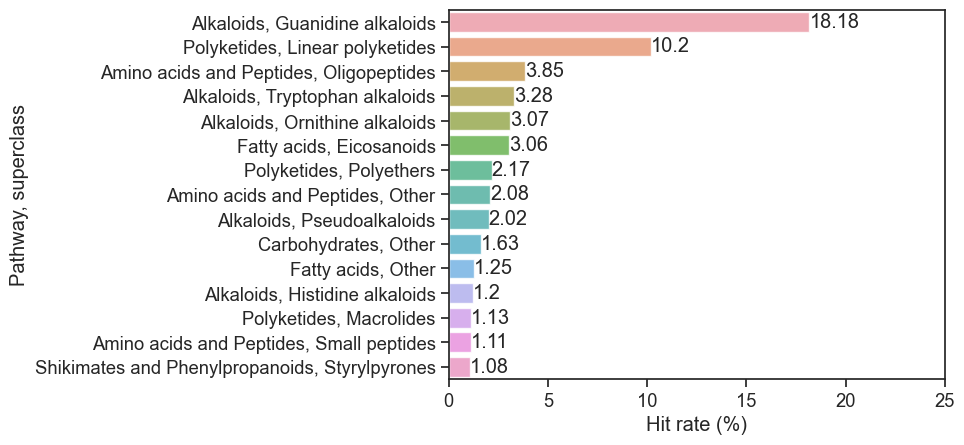

In [4]:
fig = bar(hit_rate[hit_rate['percentage'] > 1], x='percentage', y='pathway_superclass', xlim=(0, 25))
fig.set(xlabel='Hit rate (%)', ylabel = 'Pathway, superclass')
fig.figure.savefig('../plot/4-hit_rate_bar.svg', transparent=True)

In [5]:
np_ha.to_csv('../plot/4-np_ha.csv', index=False)
np_ha.shape

(825, 13)

In [6]:
data = np_ha[np_ha['superclass'] == 'Tryptophan alkaloids']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 25555 to 24739
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity_id         254 non-null    int64  
 1   assay_id            254 non-null    int64  
 2   standard_type       254 non-null    object 
 3   pchembl_value       254 non-null    float64
 4   tid                 254 non-null    int64  
 5   target_type         254 non-null    object 
 6   pref_name           254 non-null    object 
 7   class_level         254 non-null    float64
 8   lotus_id            254 non-null    object 
 9   pathway             254 non-null    object 
 10  superclass          254 non-null    object 
 11  class               254 non-null    object 
 12  pathway_superclass  254 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 27.8+ KB


In [7]:
np_ha['superclass'].unique().shape

(46,)

In [8]:
data = np_ha[np_ha['superclass'] == 'Eicosanoids']
data.shape

(10, 13)

In [9]:
data['lotus_id'].value_counts().shape

(4,)

In [10]:
data['lotus_id'].unique().shape

(4,)

In [11]:
data[data['lotus_id'] == 'LTS0171945'].value_counts(subset='pref_name')

Series([], Name: count, dtype: int64)

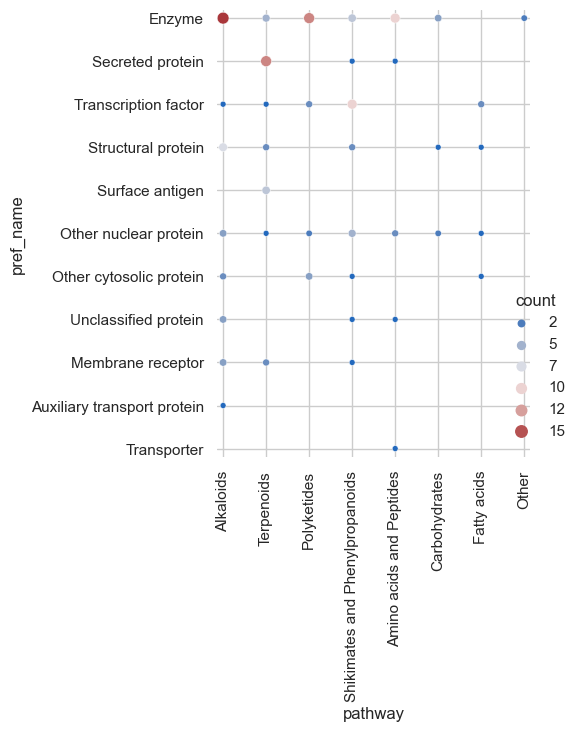

In [12]:
rel_count(np_ha[np_ha['class_level'] == 1], x='pathway', y='pref_name', count_thd = 1, figsize=(5,5))

## value counts based on superclass and tid

In [13]:
# pathway_select = hit_rate[hit_rate['percentage'] > 3]['pathway_superclass'].str.split(', ',expand=True)[0].unique()
# superclass_select = hit_rate[hit_rate['percentage'] > 3]['pathway_superclass'].str.split(', ',expand=True)[1].unique()
# superclass_select

In [14]:
ptsc_select = hit_rate[hit_rate['percentage'] > 3]['pathway_superclass'].values
ptsc_select

array(['Alkaloids, Guanidine alkaloids',
       'Polyketides, Linear polyketides',
       'Amino acids and Peptides, Oligopeptides',
       'Alkaloids, Tryptophan alkaloids',
       'Alkaloids, Ornithine alkaloids', 'Fatty acids, Eicosanoids'],
      dtype=object)

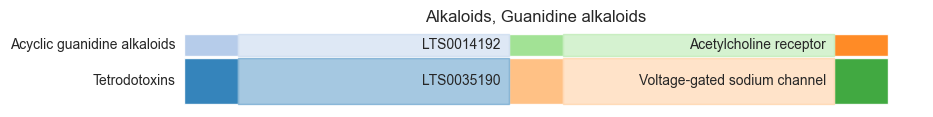

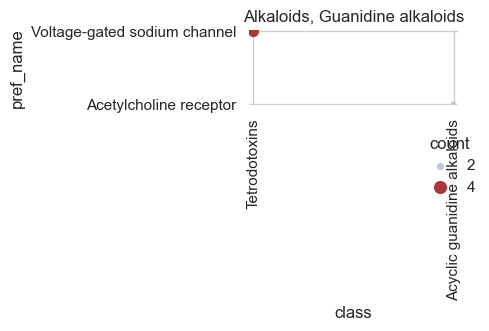

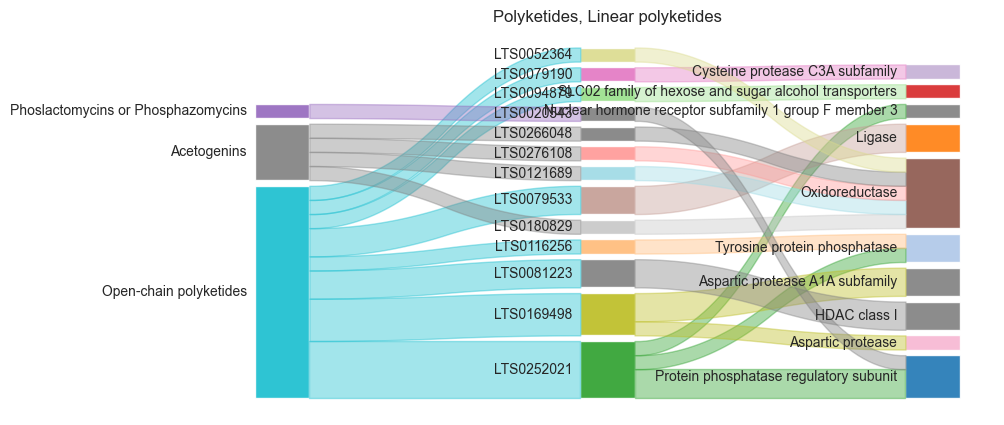

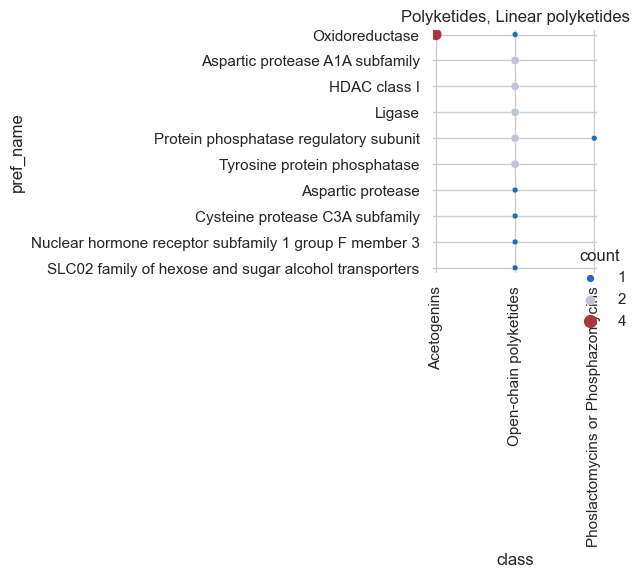

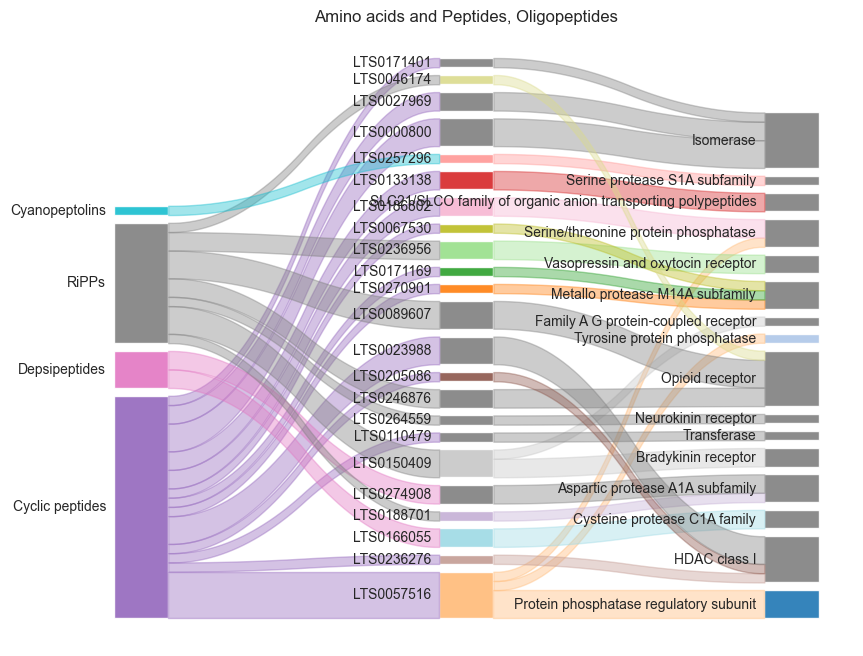

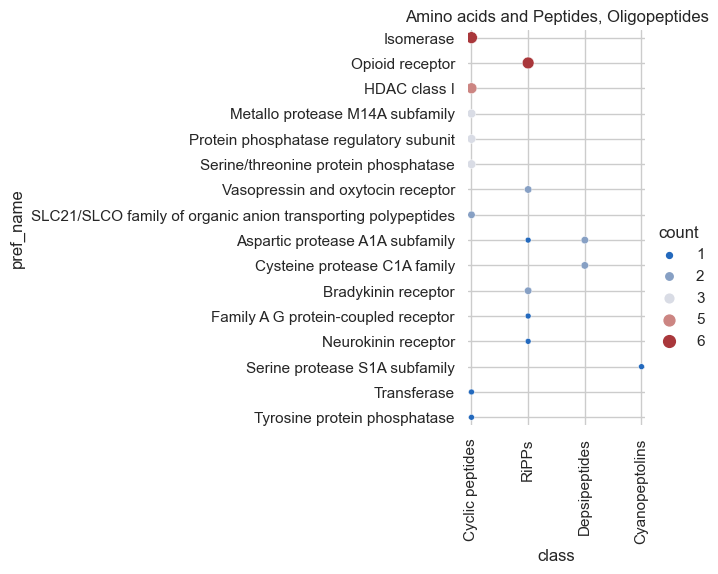

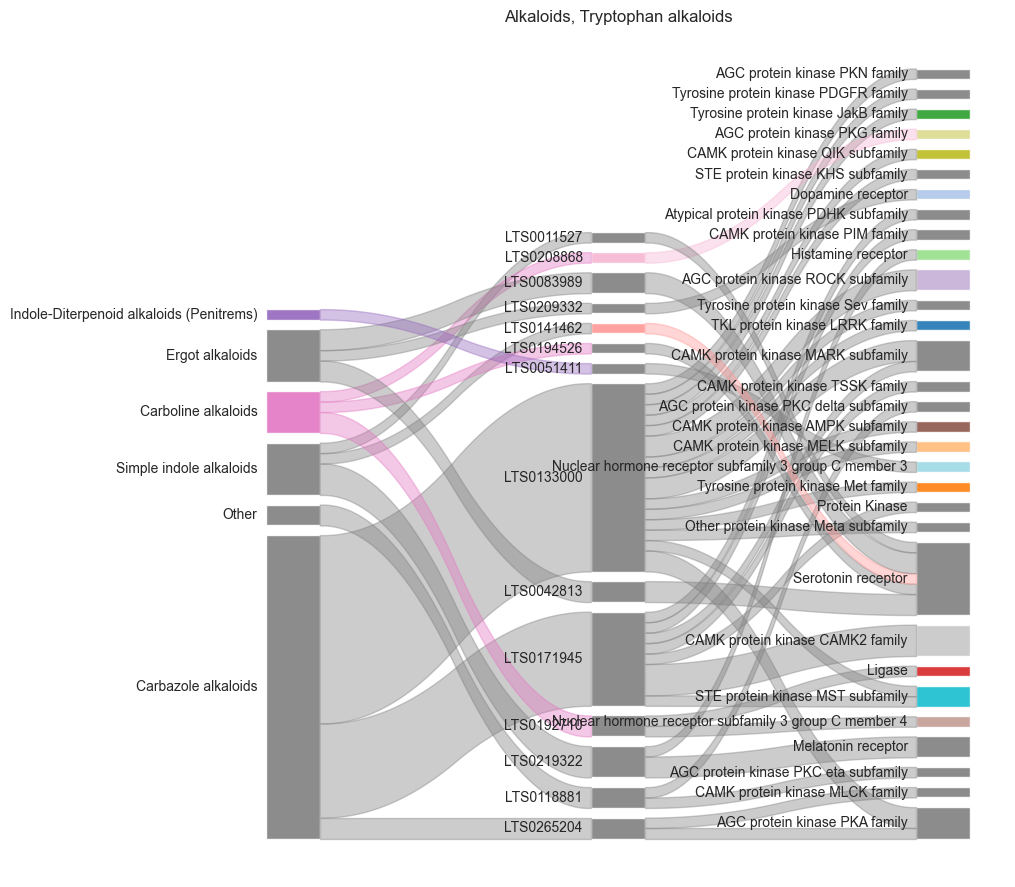

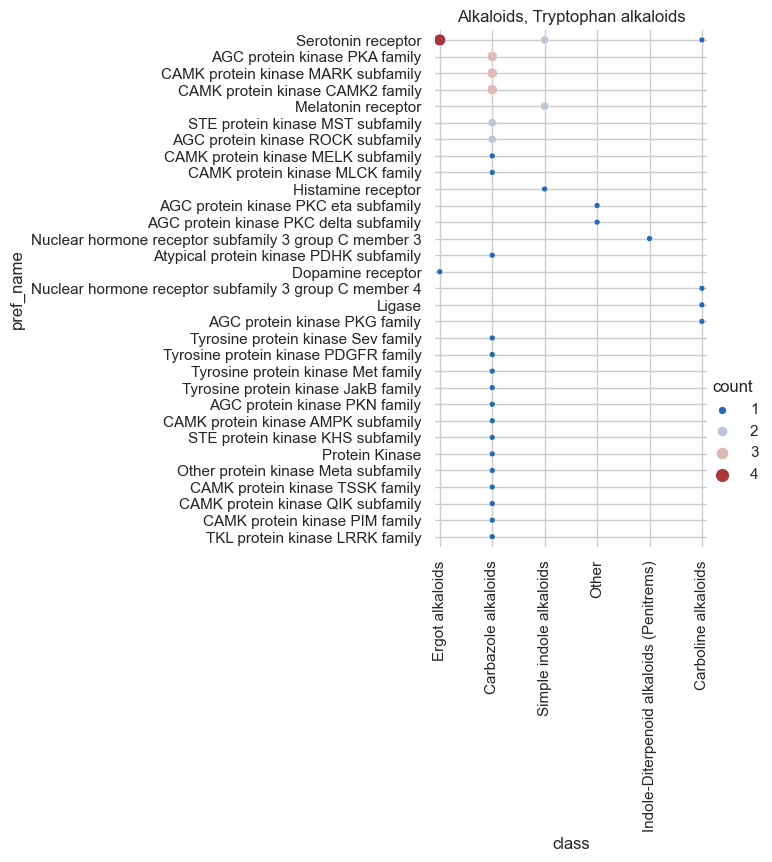

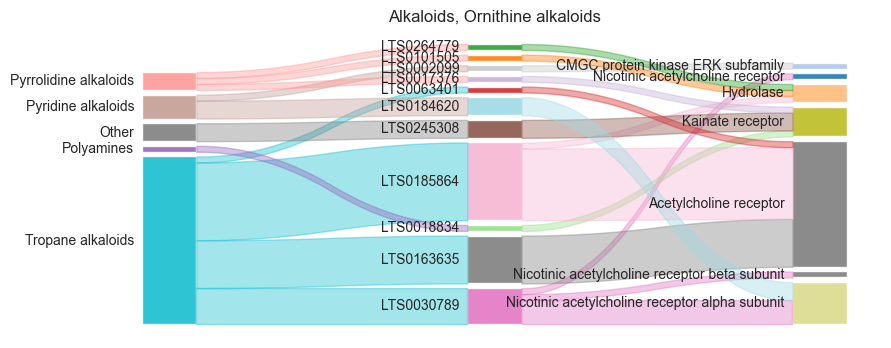

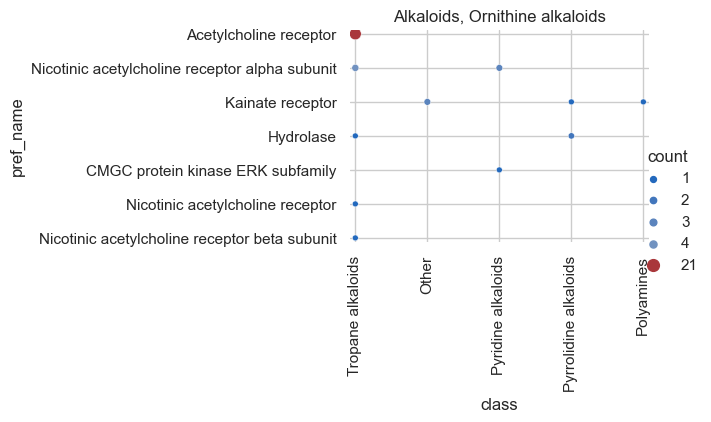

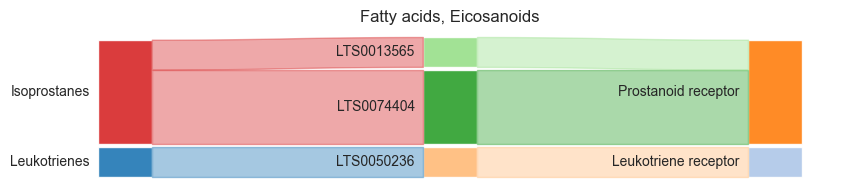

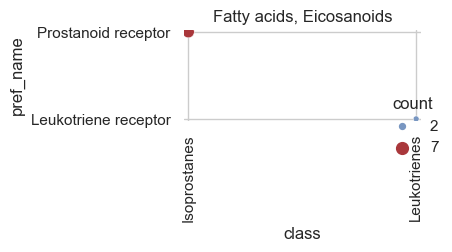

In [15]:
from pysankey2 import Sankey

for ptsc in ptsc_select:
    cdt1 = np_ha['pathway_superclass'] == ptsc
    cdt2 = np_ha['class_level'] >= 2
    data = np_ha[cdt1 & cdt2]
    if 'Tryptophan' in ptsc:
        data = data[data['pchembl_value'] > 9]
    n_height = max(data['pref_name'].unique().shape[0],
                   data['lotus_id'].unique().shape[0])
    n_width = data['class'].unique().shape[0]
    
    sky = Sankey(data[['class', 'lotus_id', 'pref_name']],
                    stripColor='left',
                    colorMode="global")
    fig,ax = sky.plot()

    fig.set_figheight(int(n_height/3) + 1)
    ax.set(title=ptsc)
    fig.figure.savefig(f'../plot/4-class_target_sankey_{ptsc}.svg', transparent=True)

    fig2 = rel_count(data, x='class', y='pref_name', title=ptsc,figsize=(1.5+n_width, n_height*0.17+0.5))
    fig2.figure.savefig(f'../plot/4-class_target_rel_{ptsc}.svg', transparent=True)

## Active, inactive, unknown ?

In [16]:
sql = '''SELECT np_activities.* FROM np_activities '''
np_activities = pd.read_sql(sql, conn)

active_id = set(np_activities[np_activities['pchembl_value']>8]['lotus_id'].unique())
print(len(active_id))

inactive_id = set(np_activities['lotus_id'].unique()) - active_id
print(len(inactive_id))

841
35439


In [17]:
np['isActive'] = 'unknown'
np.loc[np['lotus_id'].isin(active_id),'isActive'] = 'active'
np.loc[np['lotus_id'].isin(inactive_id),'isActive'] = 'inactive'
np[np['isActive'] == 'unknown'].shape

(240238, 9)

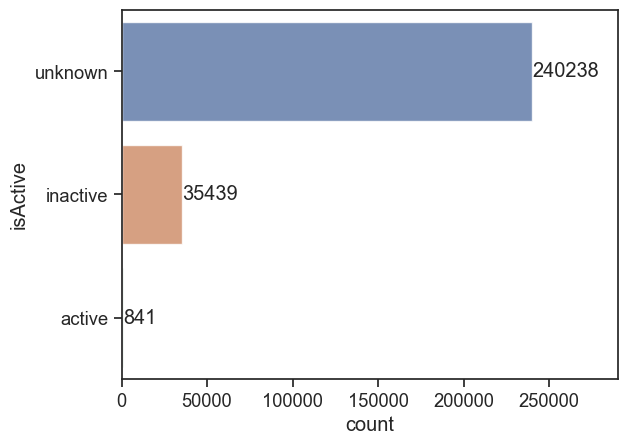

In [18]:
data = np.value_counts(subset='isActive').reset_index()
fig = bar(data, y='isActive', x='count', xlim=(0,290000))
fig.figure.savefig('../plot/4-actvie_inactive.svg', transparent=True)